In [1]:
import re
import subprocess
from pathlib import Path
from collections import defaultdict
from typing import Optional
from multiprocessing import cpu_count

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from rdkit import Chem
from rdkit import RDLogger

In [3]:
import src.utils as ut
from src.tokenizer import ChemSMILESTokenizer

In [4]:
from src.prediction import MTProductPredictor, MTReagentPredictor

In [5]:
RDLogger.DisableLog('rdApp.*')
tqdm.pandas()

In [6]:
def canonicalize_reaction(smi: str) -> str:
    left, center, right = smi.split(">")
    try:
        left = ".".join([Chem.MolToSmiles(Chem.MolFromSmiles(s), isomericSmiles=False) for s in left.split(".")])
        center = ".".join([Chem.MolToSmiles(Chem.MolFromSmiles(s), isomericSmiles=False) for s in center.split(".")])
        right = ".".join([Chem.MolToSmiles(Chem.MolFromSmiles(s), isomericSmiles=False) for s in right.split(".")])
    except:
        return smi
    else:
        return left + ">" + center + ">" + right
    
    
def canonicalize_smiles(m: str) -> str:
    mol = Chem.MolFromSmiles(m)
    if mol is not None:
        return Chem.MolToSmiles(mol, isomericSmiles=False)
    else:
        return ''

### Loading data

In [7]:
data = pd.read_csv("data/raw/Reaxys_for_Mikhail.csv", 
                   usecols=["Reaction", "Reagent SMILES", "Solvent SMILES", "Catalyst SMILES", "General class", "Numeric class"])

In [8]:
data = data.fillna("")
data = data.drop(data[data["General class"] == ''].index)
data = data.drop(data[data["Reaction"] == ''].index)

In [9]:
data["Reaction"] = data["Reaction"].progress_apply(canonicalize_reaction)
data["Reaction"] = data["Reaction"].apply(lambda x: x.replace("[HH]", "[H][H]"))
data = data.drop(data[data["Reaction"] == ""].index)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140168/140168 [00:56<00:00, 2481.70it/s]


In [11]:
data["Catalyst SMILES"] = data["Catalyst SMILES"].apply(lambda x: x.replace("[HH]", "[H][H]"))
# data["Catalyst SMILES"] = data["Catalyst SMILES"].apply(drop_duplicate_molecules)
data["Catalyst SMILES"] = data["Catalyst SMILES"].apply(canonicalize_smiles)

In [13]:
# data["Solvent SMILES"] = data["Solvent SMILES"].apply(drop_duplicate_molecules)
data["Solvent SMILES"] = data["Solvent SMILES"].apply(canonicalize_smiles)

In [14]:
data["Reagent SMILES"] = data["Reagent SMILES"].apply(lambda x: x.replace("[HH]", "[H][H]"))
# data["Reagent SMILES"] = data["Reagent SMILES"].apply(drop_duplicate_molecules)
data["Reagent SMILES"] = data["Reagent SMILES"].apply(canonicalize_smiles)

In [15]:
data["Reagents"] = data["Catalyst SMILES"] + "." + data["Reagent SMILES"] + "." + data["Solvent SMILES"]
data["Reagents"] = data["Reagents"].apply(lambda x: x.replace("..", ".").strip("."))

In [16]:
data = data.drop(data[data["Reagents"] == ""].index)  # All reactions will have some reagents

In [17]:
data["Products"] = data["Reaction"].str.split(">>", expand=True)[1]

In [22]:
def insert_reagents(rxn, rgs):
    left, right = rxn.split(">>")
    return left + ">" + rgs + ">" + right

def only_precursors(rxn):
    left, center, right = rxn.split(">")
    return (left + ">" + center).strip('.')

data["FullR"] = data[["Reaction", "Reagents"]].apply(lambda x: insert_reagents(x[0], x[1]), axis=1)
data["Precursors"] = data["FullR"].apply(only_precursors)

In [23]:
data["General class"].value_counts()

Heteroatom alkylation and arylation                                    30729
Acylation and related processes                                        23531
Deprotections                                                          21189
C-C bond formation                                                     19707
Functional group addition (FGA)                                        15629
Oxidations                                                             11622
Reductions                                                              6205
Functional group addition (FGA)/Heteroatom alkylation and arylation     6203
Protections                                                             1788
Functional group interconversion (FGI)                                  1665
Name: General class, dtype: int64

In [24]:
data.head()

,Reaction,Reagent SMILES,Solvent SMILES,Catalyst SMILES,General class,Numeric class,Reagents,Products,FullR,Precursors
0,OC1CN(Cc2ccccc2)CC1O>>OC1CNCC1O,[H][H],CO,[Pd],Deprotections,6.1.5,[Pd].[H][H].CO,OC1CNCC1O,OC1CN(Cc2ccccc2)CC1O>[Pd].[H][H].CO>OC1CNCC1O,OC1CN(Cc2ccccc2)CC1O>[Pd].[H][H].CO
1,c1ccc(CN2CCC3(CC2)Cc2ccccc2O3)cc1>>c1ccc2c(c1)...,[H][H],CC(C)O,[Pd],Deprotections,6.1.5,[Pd].[H][H].CC(C)O,c1ccc2c(c1)CC1(CCNCC1)O2,c1ccc(CN2CCC3(CC2)Cc2ccccc2O3)cc1>[Pd].[H][H]....,c1ccc(CN2CCC3(CC2)Cc2ccccc2O3)cc1>[Pd].[H][H]....
2,OC1C2COCC1CN(Cc1ccccc1)C2>>OC1C2CNCC1COC2,[H][H],CCO,[OH-].[OH-].[Pd+2],Deprotections,6.1.5,[OH-].[OH-].[Pd+2].[H][H].CCO,OC1C2CNCC1COC2,OC1C2COCC1CN(Cc1ccccc1)C2>[OH-].[OH-].[Pd+2].[...,OC1C2COCC1CN(Cc1ccccc1)C2>[OH-].[OH-].[Pd+2].[...
3,OC1CCN(Cc2ccccc2)C1>>OC1CCNC1,[H][H],CO,[Pd],Deprotections,6.1.5,[Pd].[H][H].CO,OC1CCNC1,OC1CCN(Cc2ccccc2)C1>[Pd].[H][H].CO>OC1CCNC1,OC1CCN(Cc2ccccc2)C1>[Pd].[H][H].CO
4,Cc1ccc(O)c(Cn2c(NC3CCN(Cc4ccccc4)CC3)nc3ccc(CO...,[H][H],CO,[Pd],Deprotections,6.1.5,[Pd].[H][H].CO,Cc1ccc(O)c(Cn2c(NC3CCNCC3)nc3ccc(CO)cc32)n1,Cc1ccc(O)c(Cn2c(NC3CCN(Cc4ccccc4)CC3)nc3ccc(CO...,Cc1ccc(O)c(Cn2c(NC3CCN(Cc4ccccc4)CC3)nc3ccc(CO...


In [21]:
pr_predictor_base = MTProductPredictor(model_path="experiments/trained_models/MIT_separated_model_step_220000.pt",
                                       tokenized_path="data/test/src-test-products-base.txt", 
                                       output_path="experiments/results/test-products-base.txt",
                                       beam_size=5,
                                       gpu=0)

pr_predictor_new = MTProductPredictor(model_path="experiments/trained_models/MIT_separated_reags_top1_model_step_220000.pt",
                                      tokenized_path="data/test/src-test-products-new.txt", 
                                      output_path="experiments/results/test-products-new.txt",
                                      beam_size=5,
                                      gpu=0)

pr_predictor_mix = MTProductPredictor(model_path="experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_step_220000.pt",
                                      tokenized_path="data/test/src-test-products-mix.txt", 
                                      output_path="experiments/results/test-products-mix.txt",
                                      beam_size=5,
                                      gpu=0)

In [25]:
%%time
pr_predictor_base.predict(data.Precursors)

In [26]:
%%time
pr_predictor_new.predict(data.Precursors)

CPU times: user 1.92 s, sys: 64.3 ms, total: 1.98 s
Wall time: 44min 12s


In [27]:
%%time
pr_predictor_mix.predict(data.Precursors)

CPU times: user 1.92 s, sys: 56.3 ms, total: 1.97 s
Wall time: 44min 1s


In [28]:
pr_predictor_base.load_predictions()
pred_products_base = pr_predictor_base.predictions

In [31]:
data["prod_base_top1_match"] = data["Products"].values == pred_products_base["p_products_1"]
for i in range(1, pr_predictor_base.beam_size):
    data[f"prod_base_top{i + 1}_match"] = data[f"prod_base_top{i}_match"] | (data["Products"].values == pred_products_base[f"p_products_{i + 1}"])
print("Base: Product prediction accuracy")
data[[f"prod_base_top{i + 1}_match" for i in range(pr_predictor_base.beam_size)]].mean(axis=0)

Base: Product prediction accuracy


prod_base_top1_match    0.565618
prod_base_top2_match    0.609881
prod_base_top3_match    0.633892
prod_base_top4_match    0.646614
prod_base_top5_match    0.653000
dtype: float64

In [33]:
pr_predictor_new.load_predictions()
pred_products_new = pr_predictor_new.predictions

In [34]:
data["prod_new_top1_match"] = data["Products"].values == pred_products_new["p_products_1"]
for i in range(1, pr_predictor_new.beam_size):
    data[f"prod_new_top{i + 1}_match"] = data[f"prod_new_top{i}_match"] | (data["Products"].values == pred_products_new[f"p_products_{i + 1}"])
print("New: Product prediction accuracy")
data[[f"prod_new_top{i + 1}_match" for i in range(pr_predictor_new.beam_size)]].mean(axis=0)

New: Product prediction accuracy


prod_new_top1_match    0.588160
prod_new_top2_match    0.626248
prod_new_top3_match    0.643316
prod_new_top4_match    0.653130
prod_new_top5_match    0.657903
dtype: float64

In [35]:
pr_predictor_mix.load_predictions()
pred_products_mix = pr_predictor_mix.predictions

In [36]:
data["prod_mix_top1_match"] = data["Products"].values == pred_products_mix["p_products_1"]
for i in range(1, pr_predictor_mix.beam_size):
    data[f"prod_mix_top{i + 1}_match"] = data[f"prod_mix_top{i}_match"] | (data["Products"].values == pred_products_mix[f"p_products_{i + 1}"])
print("Mix: Product prediction accuracy")
data[[f"prod_mix_top{i + 1}_match" for i in range(pr_predictor_mix.beam_size)]].mean(axis=0)

Mix: Product prediction accuracy


prod_mix_top1_match    0.605342
prod_mix_top2_match    0.643945
prod_mix_top3_match    0.664369
prod_mix_top4_match    0.676093
prod_mix_top5_match    0.682161
dtype: float64

In [39]:
base = data[[f"prod_base_top{i + 1}_match" for i in range(pr_predictor_base.beam_size)]].mean(axis=0).values
new = data[[f"prod_new_top{i + 1}_match" for i in range(pr_predictor_new.beam_size)]].mean(axis=0).values
mix = data[[f"prod_mix_top{i + 1}_match" for i in range(pr_predictor_mix.beam_size)]].mean(axis=0).values

In [73]:
(pred_products_base["p_products_1"] == pred_products_mix["p_products_1"]).mean()

0.6648248329331443

In [97]:
cases = ["base", "new", "mix"]
_table = pd.DataFrame(np.ones((3, 3), dtype=int))
_table.columns = [i + "_fail" for i in cases]
_table.index = [i + "_hit" for i in cases]
for i in cases:
    for j in cases:
        _table.loc[f"{i}_hit", f"{j}_fail"] = data[data[f"prod_{i}_top5_match"] & ~data[f"prod_{j}_top5_match"]].shape[0]
print("Number of examples where one model gets the answer\nright in top-5 and the other does not.")
_table.style.background_gradient(cmap='Blues', axis=None)

Number of examples where one model gets the answer
right in top-5 and the other does not.


,base_fail,new_fail,mix_fail
base_hit,0,8152,5996
new_hit,8830,0,4096
mix_hit,10028,7450,0


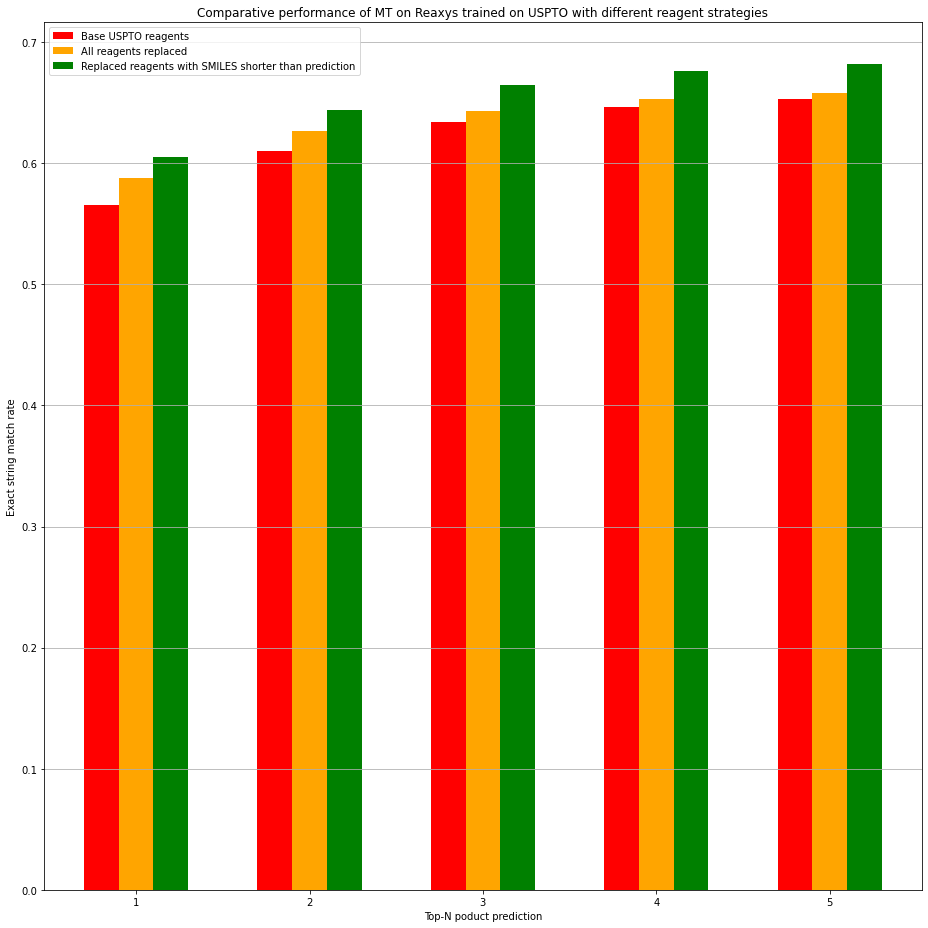

In [67]:
plt.figure(figsize=(13, 13))
plt.bar(np.arange(1, 6) - 0.2, base, width=0.2, align='center', color='red', label="Base USPTO reagents")
plt.bar(np.arange(1, 6), new, width=0.2, align='center', color='orange', label="All reagents replaced")
plt.bar(np.arange(1, 6) + 0.2, mix, width=0.2, align='center', color='green', label="Replaced reagents with SMILES shorter than prediction")
plt.grid(axis='y')
plt.gca().set_xticklabels([None, "Top-1", "Top-2", "Top-3", "Top-4", "Top-5"])
plt.ylabel("Exact string match rate")
plt.xlabel("Top-N poduct prediction")
plt.legend()
plt.title("Comparative performance of MT on Reaxys trained on USPTO with different reagent strategies")
plt.tight_layout()
plt.savefig("product_prediction_performance.png")
plt.show()